# Analisi della correlazione tra la cryptovaluta Bitcoin e Twitter

Una volta raccolti i dati, (crypto e tweets), iniziamo l'analisi per fare emergere, se esiste, una correlazione che lega le cryptovalute ai tweet. 
In particolare, osservare se il "valore" (Positivo o Negativo)
dei tweet aggregati, hanno un'influenza sull'incremento o l'abbassamento del valore delle crypto).
Normalizzando il dato e applicando i principali modelli statistici.

## Import dei moduli di  Python
Per la gestione dei dataset useremo Pandas.
Installazione dei moduli:




In [ ]:
pip install pandas

In [ ]:
pip install tqdm

In [ ]:
import json
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook, tqdm
import glob
from datetime import datetime, timedelta

## Impostare la valuta e i data file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_tweets = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KRYPTONITE/data/Twitter/Tweets_Sentiment_full.csv',  sep=',', error_bad_lines = False)
df_bitcoin = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KRYPTONITE/data/Crypto/bitcoin/Bitcoin_full.csv',  sep=';', error_bad_lines = False)

Conversione date allo stesso fuso


In [ ]:
df_tweets.head()

,Unnamed: 0,created_at,favorite_count,retweet_count,text,Follower,processed_tweets,tweets_sentiments,subjectivity,polarity,sentiment,compound,score_compund,score_polarity,score_followers_x_compound,score_followers_x_polarity
created_at,,,,,,,,,,,,,,,,
2021-08-21 04:36:37+00:00,0,2021-08-21 04:36:37+00:00,1606,261,A proposed alternative to CBC-ification for lo...,76.666667,alternative consensus mechanism moving finalit...,alternative consensus mechanism moving finalit...,0.000000,0.000000,Neutral,0.0000,0.000,0.000000e+00,0.000000,0.000000
2021-08-16 06:17:43+00:00,1,2021-08-16 06:17:43+00:00,6344,1353,"Decentralized governance is necessary, but coi...",76.666667,governance necessary coin voting governance cu...,governance necessary coin voting governance cu...,0.725000,0.125000,Positive,0.3182,2733697.566,1.073891e+06,24.395333,9.583333
2021-08-15 10:03:05+00:00,2,2021-08-15 10:03:05+00:00,723,84,@ESYudkowsky this seems like a fun coincidenta...,76.666667,like fun coincidental usual fear multifactoria...,like fun coincidental usual fear multifactoria...,0.233333,0.100000,Positive,0.3818,23495.972,6.154000e+03,29.271333,7.666667
2021-08-15 10:03:03+00:00,3,2021-08-15 10:03:03+00:00,3284,522,Another fun analysis: why is post-London chain...,76.666667,another fun analysis chain capacity higher tur...,another fun analysis chain capacity higher tur...,0.233333,0.183333,Positive,0.2500,429513.750,3.149768e+05,19.166667,14.055556
2021-08-06 08:54:37+00:00,4,2021-08-06 08:54:37+00:00,5654,814,How full blocks are in a range of EIP 1559 blo...,76.666667,full range today versus simulation two ago fai...,full range today versus simulation two ago fai...,0.613889,0.161111,Positive,0.0772,355801.290,7.425329e+05,5.918667,12.351852


In [ ]:
df_bitcoin.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
date,,,,,,,,,,
2021-09-03 01:35:00+00:00,1630632900000,2021-09-03 01:35:00+00:00,BTC/USDT,48572.47,48572.48,48531.92,48531.93,18.29788,8.884724e+05,442
2021-09-03 01:34:00+00:00,1630632840000,2021-09-03 01:34:00+00:00,BTC/USDT,48532.76,48600.35,48498.38,48572.48,86.82439,4.216322e+06,5574
2021-09-03 01:33:00+00:00,1630632780000,2021-09-03 01:33:00+00:00,BTC/USDT,48430.56,48532.79,48406.15,48532.77,56.57643,2.741462e+06,976
2021-09-03 01:32:00+00:00,1630632720000,2021-09-03 01:32:00+00:00,BTC/USDT,48368.00,48434.72,48360.09,48430.57,43.10536,2.086223e+06,986
2021-09-03 01:31:00+00:00,1630632660000,2021-09-03 01:31:00+00:00,BTC/USDT,48435.12,48444.51,48316.84,48368.00,89.52364,4.331430e+06,2304


In [ ]:
df_bitcoin['date'] = pd.to_datetime(df_bitcoin['date'], errors='coerce')

df_bitcoin['date'] = df_bitcoin['date'].dt.tz_localize('utc').dt.tz_convert('Europe/Berlin')

df_bitcoin['date'].replace({'+02:00' : ''})

df_bitcoin['date'] = pd.to_datetime(df_bitcoin['date'], utc=True, errors='coerce')

df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at'], utc=True, errors='coerce')

## Aggregazione per timeframe giornaliero




In [ ]:
df_tweets = df_tweets[(df_tweets['created_at'] > '2020-01-01 00:00:00')]

df_tweets.index = df_tweets['created_at']

df_tweets_grouped = df_tweets.groupby(pd.Grouper(key='created_at', freq = "d"))['score_followers_x_compound'].sum()

df_bitcoin = df_bitcoin[(df_bitcoin['date'] > '2020-01-01 00:00:00')]

df_bitcoin.index = df_bitcoin['date']

df_bitcoin_grouped = df_bitcoin.groupby(pd.Grouper(key='date', freq = "d"))['close'].mean()

In [ ]:
df_tweets_grouped.head()

created_at
2020-01-02 00:00:00+00:00    52.446667
2020-01-03 00:00:00+00:00     0.000000
2020-01-04 00:00:00+00:00     0.000000
2020-01-05 00:00:00+00:00    14.680000
2020-01-06 00:00:00+00:00     0.000000
Freq: D, Name: score_followers_x_compound, dtype: float64

In [ ]:
df_bitcoin_grouped.head()

date
2020-01-01 00:00:00+00:00    7213.857846
2020-01-02 00:00:00+00:00    7093.473917
2020-01-03 00:00:00+00:00    7224.443882
2020-01-04 00:00:00+00:00    7327.936375
2020-01-05 00:00:00+00:00    7431.474722
Freq: D, Name: close, dtype: float64

In [ ]:
df_tweets_grouped.to_csv('Sentiment_followers_x_compound_2020_by_day.csv')
df_bitcoin_grouped.to_csv('Bitcoin_grouped_2020_by_day.csv')

## Analisi Correlazione

Qui osserviamo l'analisi della correlazione tra l'andamento della cryptovaluta (Bitcoin) e il punteggio dei tweets che abbiamo identificato.

Possiamo testare la nostra ipotesi di correlazione usando il metodo Pandas corr(), che calcola un coefficiente di correlazione di Pearson per ogni colonna nel dataframe rispetto a ogni altra colonna


In [ ]:
# Define the cross-correlation function

def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method=method)

Consideriamo gli intervalli comuni per entrambe le serie

In [ ]:
beggining = max(df_tweets_grouped.index.min(), df_bitcoin_grouped.index.min())
end = min(df_tweets_grouped.index.max(), df_bitcoin_grouped.index.max())
df_tweets_grouped = df_tweets_grouped[beggining:end]
df_bitcoin_grouped = df_bitcoin_grouped[beggining:end]

Plottiamo l'andamento delle serie sovrapposto, in verde il valore della Sentiment ed in blu il valore della cryptovaluta

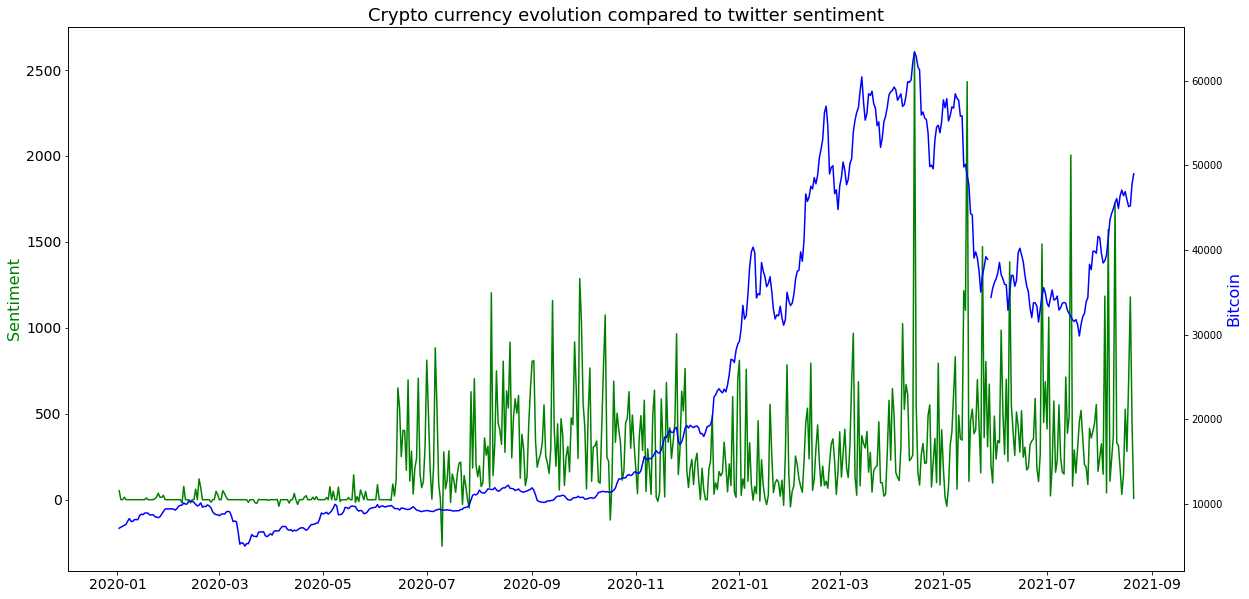

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(df_tweets_grouped.index, df_tweets_grouped, 'g-')
ax2.plot_date(df_bitcoin_grouped.index, df_bitcoin_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin", color='b', fontsize=16)
plt.show()

### Normalizzazione 
Normalizzazione dei dati


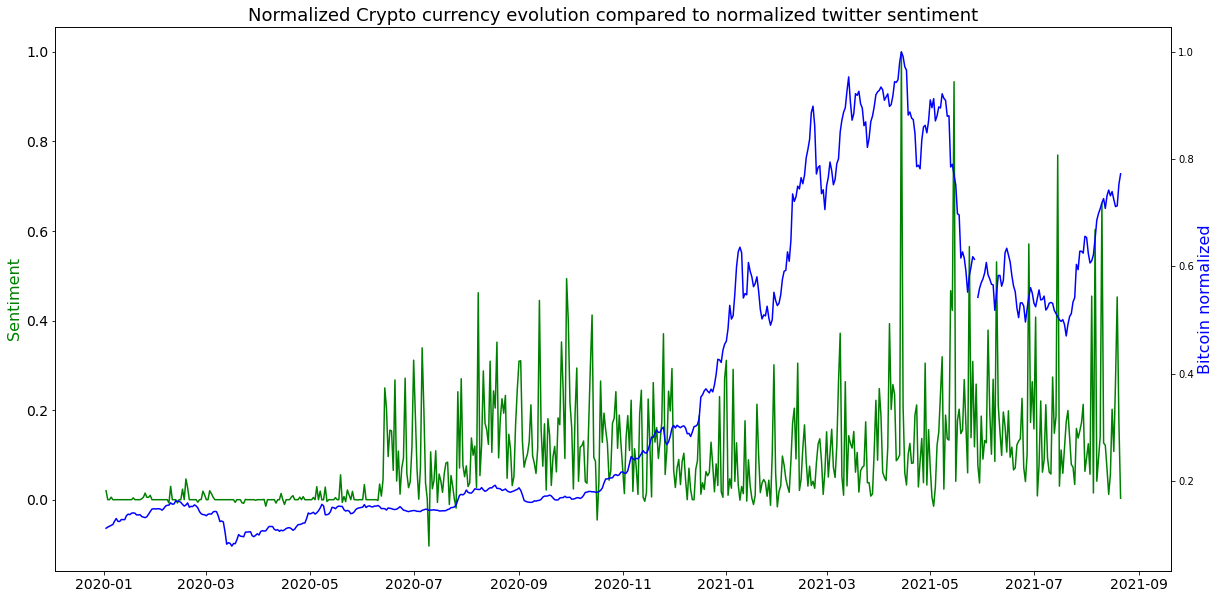

In [ ]:
df_tweets_grouped = df_tweets_grouped / max(df_tweets_grouped.max(), abs(df_tweets_grouped.min()))
df_bitcoin_grouped = df_bitcoin_grouped / max(df_bitcoin_grouped.max(), abs(df_bitcoin_grouped.min()))

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(df_tweets_grouped.index, df_tweets_grouped, 'g-')
ax2.plot_date(df_bitcoin_grouped.index, df_bitcoin_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel(f"Bitcoin normalized", color='b', fontsize=16)
plt.show()

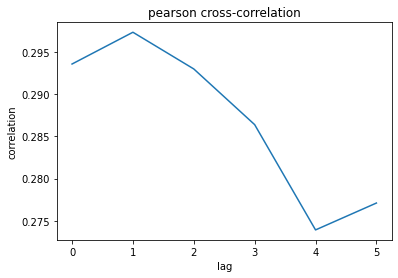

In [ ]:
#Plot normalizzato
xcov = [crosscorr(df_bitcoin_grouped, df_tweets_grouped, lag=i, method="pearson") for i in range(6)]
plt.plot(range(6), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

In [ ]:
xcov

[0.2935858598838278,
 0.2973523431838923,
 0.29300084598393467,
 0.286400331792151,
 0.2739217780026787,
 0.27710843302206045]